# Importing Libraries
## Make sure you have the requisite requirements

In [37]:
import pandas as pd
import numpy as np
import quandl
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

In [38]:
def correct_quandl_name(names):
    if isinstance(names, str):
        names = [names]
    return names

In [39]:
def request_quandl(names, start_date=None, end_date=None, token=None):
    c_names = correct_quandl_name(names)
    response = quandl.get(c_names, start_date = start_date, end_date = end_date, authtoken=token)
    return response

In [40]:
def request_yfinance(names, start_date=None, end_date=None):
    if isinstance(start_date, str):
        start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    if isinstance(end_date, str):
        start_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")
    response = yf.download(names, start=start_date, end=end_date)
    if not isinstance(response.columns, pd.MultiIndex) and len(names) > 0:
        stock_tuples = [(col, names[0]) for col in list(response.columns)]
        response.columns = pd.MultiIndex.from_tuples(stock_tuples)
    return response

In [41]:
def get_stock_data(names, start_date = None, end_date = None):
    overall_Data = {}
    for name in names:
        data = request_yfinance(name, start_date=start_date, end_date=end_date)
        overall_Data[name] = data['Adj Close']
    overall_Data = pd.concat(overall_Data, axis=1)
    return overall_Data

In [42]:
def log_hist_returns(df):
    hist_returns = np.log(df/df.shift())
    hist_returns = hist_returns.dropna()
    return hist_returns

In [43]:
def hist_mean(df):
    hist_mean = df.mean(axis=0).to_frame()
    hist_mean.columns = ['MU']
    return hist_mean.transpose()

In [44]:
def hist_cov_and_corr(df):
    hist_cov = df.cov()
    hist_corr = df.corr()
    return (hist_cov, hist_corr)

In [45]:
def construct_portfolios(names, start_date = None, end_date = None):
    
    print("----------------------------------\n")
    print("LIST OF STOCKS - \n")
    for name in names:
        print(name+"\n")
    print("----------------------------------\n")
    
    
    data = get_stock_data(names=names, start_date = '2019-01-01')
    
    hist_return = log_hist_returns(data)
    hist_mean_data = hist_mean(hist_return)
    
    print("Log Mean Returns - \n")
    print(hist_mean_data)
    print('\n\n')
    
    (hist_cov, hist_corr) = hist_cov_and_corr(hist_return)
    
    print("Historical Covariance - \n")
    print(hist_cov)
    print('\n\n')
    
    print("Historical Correlation - \n")
    print(hist_corr)
    
    #Construct random portfolios
    
    n_portfolios = 5000
    p_returns = np.zeros(n_portfolios)
    p_stddevs = np.zeros(n_portfolios)
    
    for i in range(n_portfolios):
        weights = np.random.rand(len(names))
        weights = weights/sum(weights)
        portfolio_return = np.dot(weights.transpose(), hist_mean_data.transpose())*252
        portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(hist_cov, weights))) * np.sqrt(250)
        p_returns[i] = portfolio_return
        p_stddevs[i] = portfolio_stddev
    
    #GMV
    hist_cov_inv = -np.linalg.inv(hist_cov)
    ones = np.ones(len(names))
    weights_gmv = np.dot(hist_cov_inv, ones)/(np.dot(ones.transpose(), np.dot(hist_cov_inv, ones)))
    weights_gmv_df = pd.DataFrame(data = weights_gmv).transpose()
    weights_gmv_df.columns = names
    stddev_gmv = np.sqrt(np.dot(weights_gmv.T, np.dot(hist_cov, weights_gmv))) * np.sqrt(250)
    return_gmv = np.dot(weights_gmv.transpose(), hist_mean_data.transpose())*252
    
    print("\n----------------------------------\n")
    print("Weights for global minimum variance")
    print(weights_gmv_df)
    print("\n\nVariance at GMV")
    print(stddev_gmv)
    print("\n\nReturn at GMV")
    print(return_gmv)
    
    plt.figure(figsize=(10,10))
    plt.plot(p_stddevs, p_returns, 'o')
    plt.plot(stddev_gmv, return_gmv, 'x', markersize=20)
    plt.xlabel('Expected Risk')
    plt.ylabel('Expected Return')
    plt.title('Return and Volatility of Randomly Generated Portfolios')
    plt.show()

----------------------------------

LIST OF STOCKS - 

ITC.NS

BPCL.NS

RELIANCE.NS

BEL.NS

TCS.NS

----------------------------------

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Log Mean Returns - 

      BEL.NS   BPCL.NS    ITC.NS RELIANCE.NS    TCS.NS
           B         B         I           R         T
MU  0.000749  0.000607 -0.000753    0.001614  0.000532



Historical Covariance - 

                 BEL.NS   BPCL.NS    ITC.NS RELIANCE.NS    TCS.NS
                      B         B         I           R         T
BEL.NS      B  0.000912  0.000370  0.000235    0.000292  0.000150
BPCL.NS     B  0.000370  0.000863  0.000216    0.000298  0.000155
ITC.NS      I  0.000235  0.000216  0.00

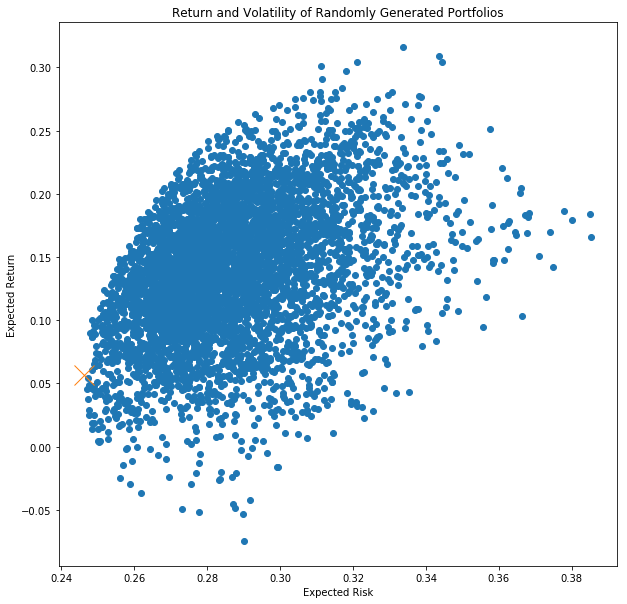

In [46]:
construct_portfolios(["ITC.NS","BPCL.NS","RELIANCE.NS","BEL.NS","TCS.NS"], start_date = '2019-01-01')